# Welcome!
Welcome to my analysis about The 2021 Kaggle Survey Data. The survey was launched with the aim of presenting a comprehensive view of the state of data science and machine learning. The survey was live from 09/01/2021 to 10/04/2021, and ends up with 25,973 responses. Analyzing this data will help us unearth many insights about the state of data science and machine learning, several of them include who is working with data, what’s happening with machine learning in different industries, and the best ways for new data scientists to break into the field.

Let's start by importing necessary libraries for the analysis.

## TL;DR

We know quite well about the tools data scientists use in their day-to-day job: you fetch your data from MySQL database, you write in Python using Jupyter Notebooks or R using RStudio. Then you publish it on Kaggle or GitHub. However as the load on ML teams increase, there are a lot of automation can be made using libraries or third-party software (not 3rd party software perse but pretrained nets can be an example of not starting from scratch) so that teams don't start from scratch. Among these solutions, cloud-based solutions emerge as the prime example.

but which cloud-based solutions wins? we will see the results on this notebook.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy
import re

In [2]:
# helper functions

# Input data files are available in the read-only "../input/" directory
# running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
def list_input_files():
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
def count_ma(df, normalize=False):
    if normalize == False:
        count_result = df.count()
    else:
        count_result = df.count() / df.count().sum()
    return pd.Series(count_result.values, index=df.mode().iloc[0].values)

def count_val(data, normalize=False):
    if isinstance(data, pd.Series):
        return data.value_counts(normalize=normalize).sort_values()
    elif isinstance(data, pd.DataFrame):
        return count_ma(data, normalize=normalize).sort_values()

def concat_h(ls):
    pd.concat(ls, axis=1).drop(index=['None', 'Other'])

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

After we import the necessary libraries, let us load the dataset as a Pandas DataFrame.

In [3]:
df_source = pd.read_csv('kaggle_survey_2021_responses.csv')
df_source.head()

<ipython-input-3-2862b4b2547d>:1: DtypeWarning: Columns (0,195,201,285,286,287,288,289,290,291,292) have mixed types. Specify dtype option on import or set low_memory=False.
  df_source = pd.read_csv('kaggle_survey_2021_responses.csv')


,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,...,"In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor...","In the next 2 years, do you hope to become mor..."
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN


Please note that the dataset contains exactly 369 columns, while the survey only contains about 42 questions. These additional columns are due to some questions being multiple-answers (not to confuse with multiple-choices) so that the columns are accomodated for maximum number of answers. We will see these columns later, but we can leave it for now.

Another thing to note is that we received a DtypeWarning. This is because the first row in the DataFrame contains the survey questions. We will dump this row onto another DataFrame called 'df_questions', and the survey answers as 'df'.

In [4]:
df_questions = df_source.loc[0,:]
df = df_source.loc[1:,:]
df_questions.head()

Time from Start to Finish (seconds)                                Duration (in seconds)
Q1                                                           What is your age (# years)?
Q2                                                What is your gender? - Selected Choice
Q3                                             In which country do you currently reside?
Q4                                     What is the highest level of formal education ...
Name: 0, dtype: object

We received no more warning. After we successfully load the dataset, we will then check the integrity of the dataset,

In [5]:
na_values = df.isna().sum().to_frame(name='null').T
pd.concat([df.describe(),na_values])

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
count,25973,25973,25973,25973,25973,25973,25973,21860,5334,10756,...,633,591,4239,729,737,1020,666,2747,4542,377
unique,5409,11,5,66,7,15,7,1,1,1,...,1,1,1,1,1,1,1,1,1,1
top,484,25-29,Man,India,Master’s degree,Student,1-3 years,Python,R,SQL,...,Comet.ml,Sacred + Omniboard,TensorBoard,Guild.ai,Polyaxon,ClearML,Domino Model Monitor,MLflow,None,Other
freq,42,4931,20598,7434,10132,6804,7874,21860,5334,10756,...,633,591,4239,729,737,1020,666,2747,4542,377
null,0,0,0,0,0,0,0,4113,20639,15217,...,25340,25382,21734,25244,25236,24953,25307,23226,21431,25596


We can see that the first to seventh column is well integrated. In fact, the kaggle team already pre-cleaned the survey dataset before releasing it so we could spend less time cleaning and more time analyzing. However, what about the column Q7_Part_1 and the other columns that has "_Part_X" suffix on it? we saw a lot of missing values on those columns! no need to worry, those are the multiple-answers columns i was talking about, so each columns will have a healthy number of missing data, but these missing data represents that a survey respondents didn't select a particular column (which are represented by a column).

For now, we will focus our attention on the Q1, Q2 and Q3 column, which columns contain answers about the demographics of the respondents.

# Demographics

## Country of Origin, Age and Gender

First off, we will break down the demographics of those who responded to the survey. There are however, a lot of demographic questions being asked on the survey. We will divide those questions in two parts: the first part (which we are going to take a look now) contains a more general demographic data, like age, gender and country of origin. let us get straight into it by plotting the survey results!

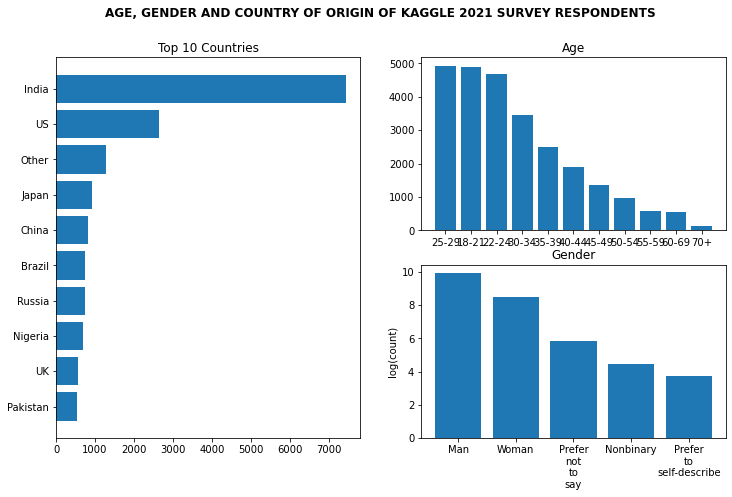

In [6]:
#prepare the data
top_countries = df['Q3'].value_counts().head(10).sort_values().reset_index()
top_countries['index'] = top_countries['index'].replace({'United Kingdom of Great Britain and Northern Ireland': 'UK', 
                                                         'United States of America': 'US'})
age = df['Q1'].value_counts()
gender = np.log(df['Q2'].value_counts()).reset_index()
gender['index'] = gender['index'].str.replace(' ', '\n')

#render figure
f, ax = plt.subplot_mosaic([[0,1],[0,2]], figsize=(12,7))
#draw axes
ax[0].barh(top_countries['index'], top_countries['Q3'])
ax[0].set_title('Top 10 Countries')

ax[1].bar(age.index, age.values)
ax[1].set_title('Age')

ax[2].bar(gender['index'], gender['Q2'])
ax[2].set_title('Gender')
ax[2].set_ylabel('log(count)')
#add suptitle
plt.suptitle('AGE, GENDER AND COUNTRY OF ORIGIN OF KAGGLE 2021 SURVEY RESPONDENTS', fontweight='bold')
plt.show()

From the data above, we can see that the largest groups of the respondents were dominated by males aged 18-29 years old. India, by a lot margin, led the way as the top country of origin of the survey respondents. After India, the US follows, and then those who answered "Other". 4 Asian countries were among the top 10: India, Japan, China and Pakistan, while Brazil represents the largest group from the South American continent, Nigeria represents the African continent, and finally Russia and United Kingdom represents the European continent.

Please note that i applied logarithmic transformations to the gender data for the visualizations.

Next, we will look at the respondents' education, occupation and years of coding experience.

 ## Education, Occupation and Years of Coding Experience
 
 For each survey answers, we will count each respondents' answers then plot it with matplotlib.

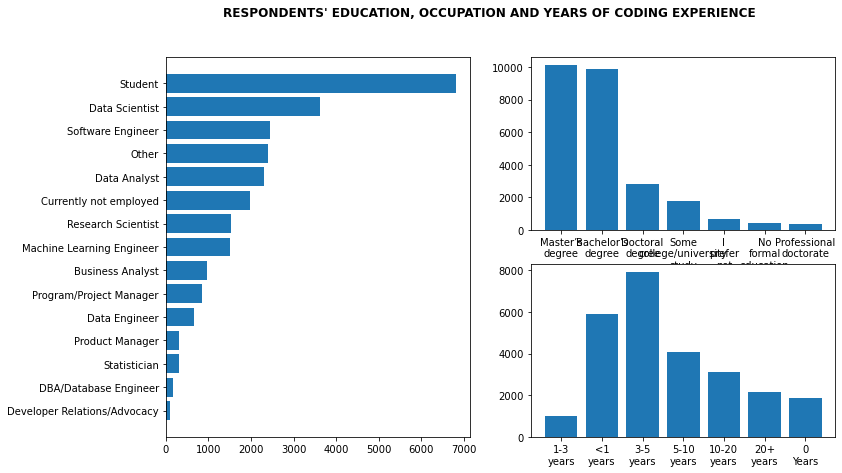

In [7]:
occupation = df['Q5'].value_counts().sort_values()

education = df['Q4'].value_counts().reset_index()
education['index'] = education['index'].str.replace(' ', '\n')

coding_exp = df['Q6'].value_counts().reset_index()
coding_exp['index'] = coding_exp['index'].replace({'I have never written code':'0 Years', '< 1 years': '<1 years'}).str.replace(' ', '\n')
coding_exp['sorter'] = coding_exp['index'].replace({'0\nYears':0,
                                                     '<1\nyears':1,
                                                     '1-3\nyears':2,
                                                     '3-5\nyears':3,
                                                     '5-10\nyears':4,
                                                     '10-20\nyears':5,
                                                     '20+\nyears':6})

coding_exp.sort_values(by='sorter')

f, ax = plt.subplot_mosaic([[0,1],[0,2]], figsize=(12,7))

ax[0].barh(occupation.index, occupation.values)
ax[1].bar(education['index'], education['Q4'])
ax[2].bar(coding_exp['sorter'], coding_exp['Q6'])
ax[2].set_xticks(np.arange(7))
ax[2].set_xticklabels(coding_exp['index'])
f.suptitle("RESPONDENTS' EDUCATION, OCCUPATION AND YEARS OF CODING EXPERIENCE", fontweight='bold')
plt.show()

From the visualizations that we have created, it is revealed that most kaggle respondents either have or currently pursuing a Bachelor's or Master's degree. The largest percentage of kaggle survey respondents are students, followed by Data Scientists, Software Engineers, those who answered "Other", and Data Analysts. The respondents have mostly 1-3 years of coding experience under their belt.

# Tools of The Job: What do the respondents use on a daily basis?

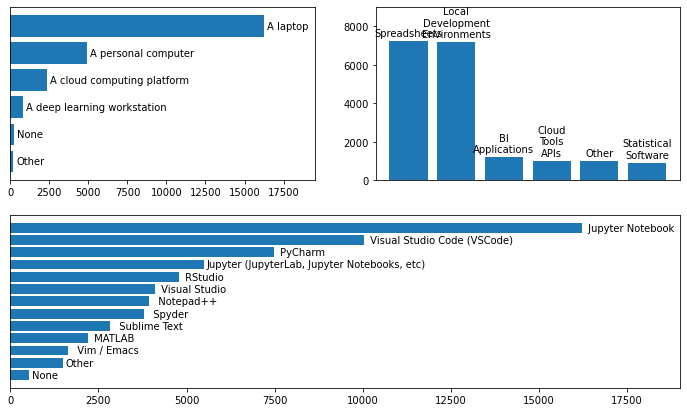

In [8]:
ide = count_val(df.loc[:,'Q9_Part_1':'Q9_OTHER'])

tools = df['Q11'].value_counts().sort_values().reset_index()
tools['index'] = tools['index'].str.replace(r' \(.+\)| /.+', '', regex=True)

analysis_tools = df['Q41'].value_counts().reset_index()
analysis_tools['shorthand'] = analysis_tools['index'].replace({'Basic statistical software (Microsoft Excel, Google Sheets, etc.)':'Spreadsheets',
                                 'Local development environments (RStudio, JupyterLab, etc.)': 'Local\nDevelopment\nEnvironments',
                                 'Business intelligence software (Salesforce, Tableau, Spotfire, etc.)': 'BI\nApplications',
                                 'Cloud-based data software & APIs (AWS, GCP, Azure, etc.)': 'Cloud\nTools\nAPIs',
                                 'Advanced statistical software (SPSS, SAS, etc.)': 'Statistical\nSoftware'})

f, ax = plt.subplot_mosaic([[0,1],[2,2]], figsize=(12,7))

rect_tools = ax[0].barh(tools['index'], tools['Q11'])
ax[0].bar_label(rect_tools, labels=tools['index'], padding=3)
ax[0].tick_params(left=False, labelleft=False)
ax[0].set_xlim(0,19500)

rect_eda = ax[1].bar(analysis_tools.index, analysis_tools['Q41'])
ax[1].bar_label(rect_eda, labels=analysis_tools['shorthand'], padding=3)
ax[1].set_ylim(0,9000)
ax[1].tick_params(bottom=False, labelbottom=False)

rect_ide = ax[2].barh(ide.index, ide.values)
ax[2].bar_label(rect_ide, labels=ide.index, padding=3)
ax[2].set_xlim(0,19000)
ax[2].tick_params(left=False, labelleft=False)

plt.show()

We can see that most survey respondents use laptops. Note that the survey question has potential to be redundant, as, for instance, those who use a laptop can also utilize a cloud computing platform. However, the author assumes that those who answered that they use a laptop, desktop or workstation works on their projects locally, while those who use cloud computing platforms mean that they use any environment hosted on the cloud.

The data tells us that spreadsheets and development environments are used the most. This is probably because both of these tools are flexible and general-purpose in nature. On the other hand, BI tools, cloud-based tools and statistical softwares are more niche and geared towards a more specific use-case.

Lastly, most of the respondents use Jupyter Notebooks, followed by VSCode and PyCharm. Note that unlike VSCode or PyCharm, jupyter notebook is a platform more geared towards interactive computing and therefore more associated closely with data analytics and data science. 

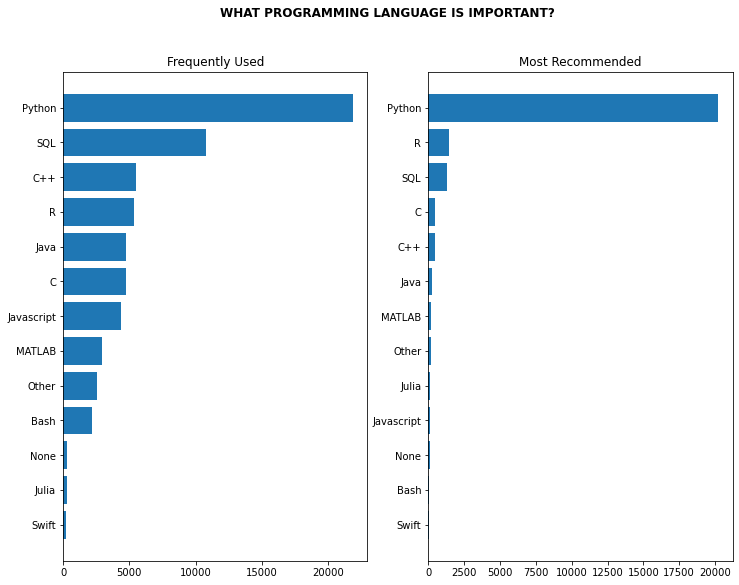

In [9]:
pl_used = count_val(df.loc[:,'Q7_Part_1':'Q7_OTHER'])
pl_rec = count_val(df['Q8'])

f, ax = plt.subplot_mosaic([[0,1]],figsize=(12,9))
ax[0].barh(pl_used.index, pl_used.values)
ax[0].set_title('Frequently Used')
ax[1].barh(pl_rec.index, pl_rec.values)
ax[1].set_title('Most Recommended')
f.suptitle('WHAT PROGRAMMING LANGUAGE IS IMPORTANT?', fontweight='bold')
plt.show()

We can see that Python, R and SQL are the top three most recommended language for data science. This is not a surprise, since these three languages have terrific community support for data science and they are free. looking at the most frequently used language, we can see that there is a very slight deviation: C++ are used more often than R (). It may be compelling to ask why data scientists use C++, but it's important to remember that those who answered this survey is not only data scientists or data analysts. Furthermore, there is a possibility that data scientists/analysts can even use C++ outside their day-to-day job (for a side project, as an example). Therefore, we don't know whether C++ is used for data science or a more general programming. Next, we can see that Python is getting recommended more than its counterparts, with the results skewing heavily.

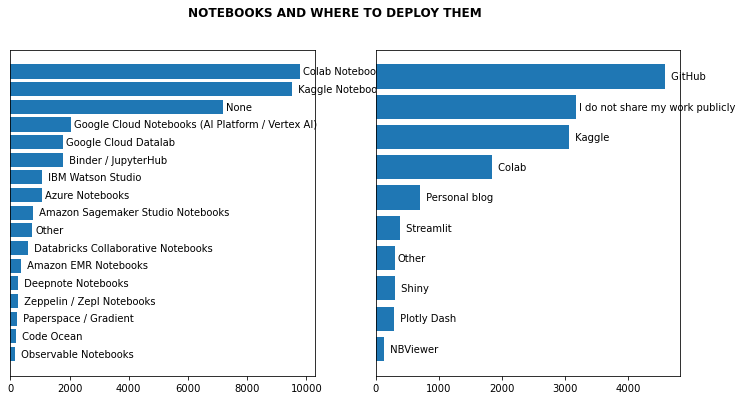

In [10]:
notebook = count_val(df.loc[:,'Q10_Part_1':'Q10_OTHER'])
deployment_site = count_val(df.loc[:,'Q39_Part_1':'Q39_OTHER'])

f, ax = plt.subplot_mosaic([[0,1]], figsize=(12, 6))\

rect_nb = ax[0].barh(notebook.index, notebook.values)
ax[0].bar_label(rect_nb, notebook.index, padding=3)

rect_dep = ax[1].barh(deployment_site.index, deployment_site.values)
ax[1].bar_label(rect_dep, deployment_site.index, padding=3)

for a in range(2):
    ax[a].tick_params(left=False, labelleft=False)
f.suptitle('NOTEBOOKS AND WHERE TO DEPLOY THEM', fontweight='bold')
plt.show()

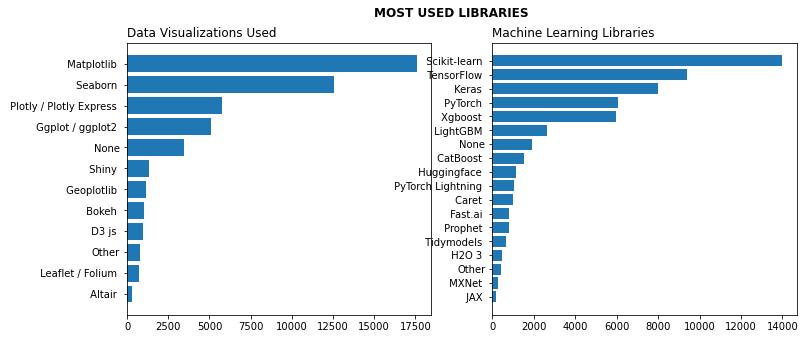

In [11]:
dataviz = count_val(df.loc[:,'Q14_Part_1':'Q14_OTHER'])
ml_frameworks = count_val(df.loc[:,'Q16_Part_1':'Q16_OTHER'])

f, ax = plt.subplot_mosaic([[0,1]], figsize=(12,5))
ax[0].barh(dataviz.index, dataviz.values)
ax[0].set_title('Data Visualizations Used', loc='left')

ax[1].barh(ml_frameworks.index, ml_frameworks.values)
ax[1].set_title('Machine Learning Libraries', loc='left')

f.suptitle('MOST USED LIBRARIES', fontweight='bold')

plt.show()

## What algorithms are used the most and required by the industry?

Next, we will take a look at how data analysts and data scientists work in their day-to-day job. We will look at what algorithm they choose, what cloud provider they choose or whether they use more niche tools like AutoML. Then, we will break the data down by company size and ML deployment stage. Analyzing this data will give us some insight about what is expected from each data scientists, or how do they work on their projects once they get accepted by the companies.

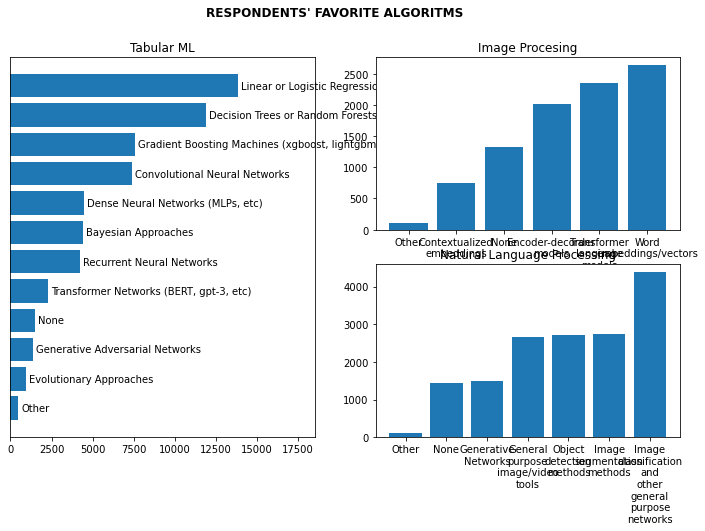

In [12]:
ml_alg = count_val(df.loc[:,'Q17_Part_1':'Q17_OTHER'])

nlp_alg = count_val(df.loc[:,'Q19_Part_1':'Q19_OTHER']).reset_index()
nlp_alg['index'] = nlp_alg['index'].str.replace(r' \(.+\)| /.+', '', regex=True)
nlp_alg['index'] = nlp_alg['index'].str.replace(' ', '\n')

cv_alg = count_val(df.loc[:,'Q18_Part_1':'Q18_OTHER']).reset_index()
cv_alg['index'] = cv_alg['index'].str.replace(r' \(.+\)| /.+', '', regex=True)
cv_alg['index'] = cv_alg['index'].str.replace(' ', '\n')

#ml
f, ax = plt.subplot_mosaic([[0,1],[0,2]],figsize=(12,7))
rect = ax[0].barh(ml_alg.index, ml_alg.values)
ax[0].bar_label(rect, labels=ml_alg.index, padding=3)
ax[0].set_title("RESPONDENTS' FAVORITE ALGORITHMS", fontweight='bold')
ax[0].tick_params(left=False, labelleft=False)
ax[0].set_xlim(0,18500)
#nlp
ax[1].bar(nlp_alg['index'], nlp_alg[0])
#cv
ax[2].bar(cv_alg['index'], cv_alg[0])

title = ['Tabular ML', 'Image Procesing', 'Natural Language Processing']
for a,t in zip(np.arange(3), title):
    ax[a].set_title(t)

f.suptitle("RESPONDENTS' FAVORITE ALGORITMS", fontweight='bold')
plt.show()

We can see that the respondents use linear or regression methods very often, followed by decision trees or random forests, then finally gradient boosting methods. It is well known that data scientists/analysts often employ linear or logistic methods as a baseline or to solve simple problems. On the other hand, Gradient boosting methods are known to win several kaggle competitions (). Lastly, it is quite surprising for me to see decision trees or random forests at the top, maybe this is because they are simple enough to understand, although from the author's experience, they are not always accurate.

Text(0.5, 0.98, 'TYPES OF INDUSTRY AND COMPANY SIZE')

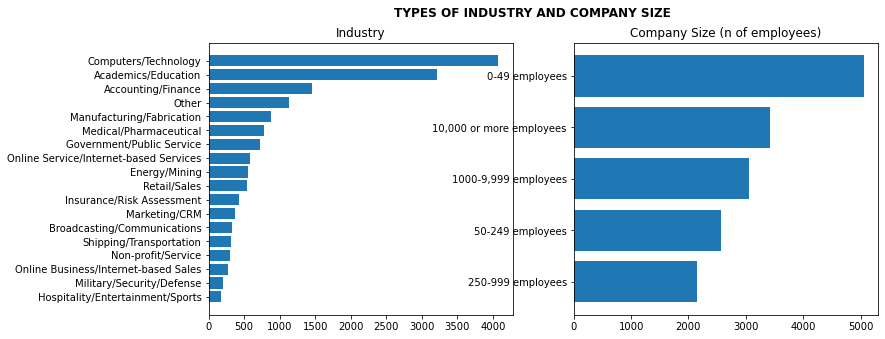

In [13]:
ind = count_val(df['Q20'])
comp_size = count_val(df['Q21'])

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.barh(ind.index, ind.values)
ax1.set_title('Industry')


ax2.barh(comp_size.index, comp_size.values)
ax2.set_title('Company Size (n of employees)')

f.suptitle('TYPES OF INDUSTRY AND COMPANY SIZE', fontweight='bold')

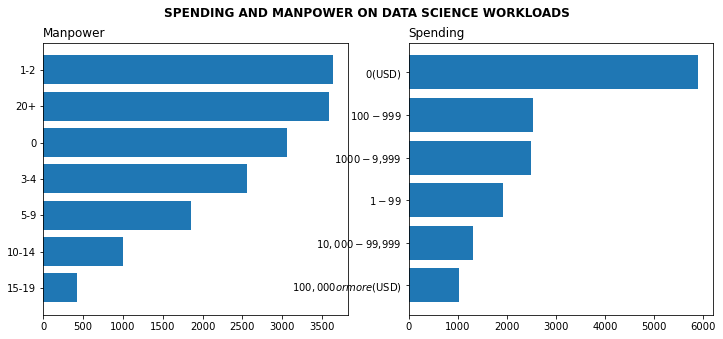

In [14]:
ds_manpower = count_val(df['Q22'])
ml_spending = count_val(df['Q26'])

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.barh(ds_manpower.index, ds_manpower.values)
ax1.set_title('Manpower', loc='left')

ax2.barh(ml_spending.index, ml_spending.values)
ax2.set_title('Spending', loc='left')

f.suptitle('SPENDING AND MANPOWER ON DATA SCIENCE WORKLOADS', fontweight='bold')
plt.show()

In [15]:
count_val(df.loc[:,'Q24_Part_1':'Q24_OTHER'])

Other                                                                                                                677
None of these activities are an important part of my role at work                                                   2825
Do research that advances the state of the art of machine learning                                                  3160
Build and/or run a machine learning service that operationally improves my product or workflows                     3694
Experimentation and iteration to improve existing ML models                                                         3974
Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data    4562
Build prototypes to explore applying machine learning to new areas                                                  5150
Analyze and understand data to influence product or business decisions                                              9108
dtype: int64

In [16]:
count_val(df['Q23'])

We use ML methods for generating insights (but do not put working models into production)    1707
We recently started using ML methods (i.e., models in production for less than 2 years)      2247
We have well established ML methods (i.e., models in production for more than 2 years)       2633
I do not know                                                                                2712
No (we do not use ML methods)                                                                3263
We are exploring ML methods (and may one day put a model into production)                    3390
Name: Q23, dtype: int64

## Cloud Computing: What does the community use?
Let us start by finding out who the leaders are in the cloud computing industry.

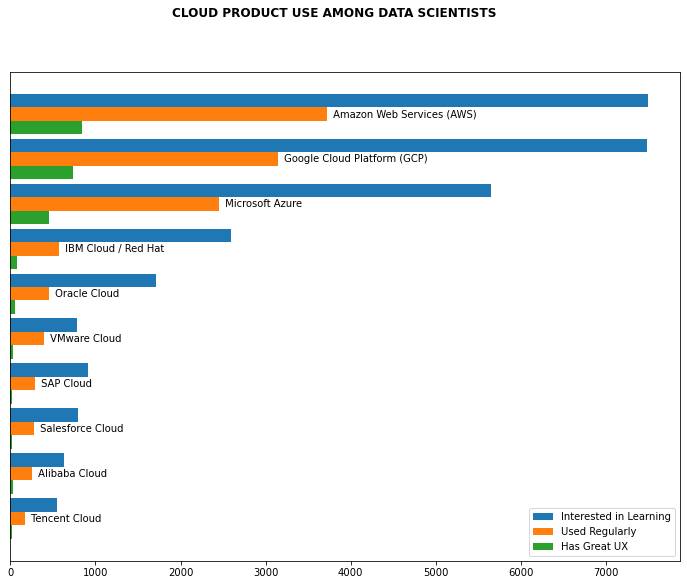

In [32]:
# cloudname_reg = re.sub(r' \(.+\) - .+ - .+', '', df_questions.Q27_A_OTHER)
cloud_reg = count_val(df.loc[:,'Q27_A_Part_1':'Q27_A_OTHER']).rename('regularly_used')
cloud_int = count_val(df.loc[:,'Q27_B_Part_1':'Q27_B_OTHER']).rename('interested')
cloud_ux = count_val(df['Q28']).rename('experience')
cloud = pd.concat([cloud_reg, cloud_int, cloud_ux], axis=1).sort_values('regularly_used', ascending=False)
#warning! this line removes some important data!
cloud = cloud.drop(index=['None', 'Other', 'None were satisfactory', 'They all had a similarly enjoyable developer experience'])

f, ax = plt.subplots(figsize=(12,9))

pos = np.arange(len(cloud.index))
height = 0.3

ax.barh(pos-height, cloud['interested'], height=height, label = 'Interested in Learning')
r_cp = ax.barh(pos, cloud['regularly_used'], height=height, label = 'Used Regularly')
ax.bar_label(r_cp, labels=cloud.index, padding=3)
ax.barh(pos+height, cloud['experience'], height=height, label = 'Has Great UX')
ax.tick_params(left=False, labelleft=False)
ax.invert_yaxis()
# ax.set_yticks(pos)
# ax.set_yticklabels(cloud.index)
ax.legend()

f.suptitle('CLOUD PRODUCT USE AMONG DATA SCIENTISTS', fontweight='bold')
plt.show()

We have created a bar plot here, plotting the counts of each service providers, with three different variables: The blue bars indicates how much respondents hoped to become more familiar with the cloud provider in question. Next, the orange bars indicates how much respondents use the cloud provider in question regularly. Finally, the green bars indicates how much respondents thought that the cloud provider in question has great UX experience.

First, let's take a look at the blue bars. Both Amazon Web Services (AWS) and Google Cloud Platform (GCP) lead ahead, with AWS emerges slightly ahead. AWS has lead the cloud computing market share for a few years from now, but GCP is catching up, and this is represented by the high count of people who are interested in being familiar with GCP. The two cloud providers are followed by Microsoft Azure in third place.

you can also see that cloud services listed by the kaggle survey has a lot of categories mixed in. For example, AWS, GCP and Microsoft Azure are Paas (Platform as a service) in nature, while Salesforce and SAP both are SaaS (software as a service). As a Data Scientist, it is understandable that they choose PaaS, as they still has control of how the data and the applications are run but do not need to manage the things like OS and runtime (). Will the survey result shift if we survey the general population instead?

In [33]:
df_questions['Q27_B_OTHER']

'Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years? - Selected Choice - Other'

In [ ]:
cloud_compute = count_val(df.loc[:,'Q29_A_Part_1':'Q29_A_OTHER'])
cloud_storage = count_val(df.loc[:,'Q30_A_Part_1':'Q30_A_OTHER'])

r_cc = ax[1].barh(cloud_compute.index, cloud_compute.values)
ax[1].bar_label(r_cc, labels=cloud_compute.index, padding=3)
ax[1].tick_params(left=False, labelleft=False)

r_cs = ax[2].barh(cloud_storage.index, cloud_storage.values)
ax[2].bar_label(r_cs, labels=cloud_storage.index, padding=3)
ax[2].tick_params(left=False, labelleft=False)
# ax[1].set_title(cloud_ux.name)

## Databases and Warehouses

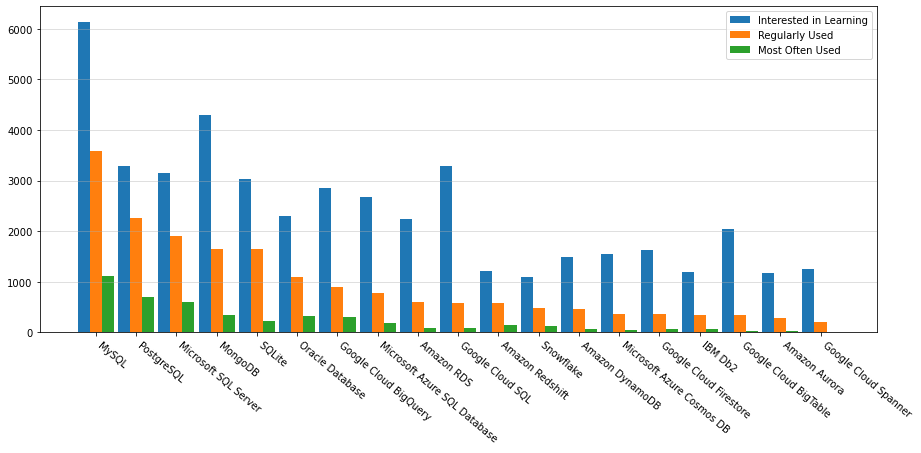

In [18]:
reg = count_val(df.loc[:,'Q32_A_Part_1':'Q32_A_OTHER']).rename(df_questions['Q32_A_OTHER'])
intsd = count_val(df.loc[:,'Q32_B_Part_1':'Q32_B_OTHER']).rename(df_questions['Q32_B_OTHER'])
oft = count_val(df.loc[:,'Q33']).rename(df_questions['Q33'])
big_data = pd.concat([reg, oft, intsd], axis=1).drop(index=['None', 'Other'])

f, ax = plt.subplots(figsize=(15,6))

pos = np.arange(len(big_data.index))
height = 0.3

ax.bar(pos+height, big_data.iloc[:,2], width=height, label = 'Interested in Learning')
ax.bar(pos, big_data.iloc[:,0], width=height, label = 'Regularly Used')
ax.bar(pos-height, big_data.iloc[:,1], width=height, label = 'Most Often Used')
ax.set_xticks(pos)
ax.set_xticklabels(big_data.index, rotation=320, ha='left')
ax.invert_xaxis()
ax.legend()
ax.grid(axis='y', alpha=0.5)
plt.show()

1. The most used products are several implementation of SQL (MySQL, PostgreSQL and Microsoft SQL Server) followed by MongoDB (a noSQL database) and SQLite.
2. Seeing which database products used regularly and the most often is not surprising: MySQL and MongoDB takes the top spot for relational database and NoSQL types, respectively. However, the level of popularity is a bit wild.
2. looks like people are interested in google products, even though these products are not used very often. All google products shown high interest. Compared to how often they are being used, people are showing relatively high interest in these products.

We will try to break this down further. because there are several products that shown relatively high interest compared to its actual use in the field, we will inspect this phenomenon in more detail. In order to do this, we will sort this product using a new metric. We will get the respondents' level of interest towards a relational database product, then divide it with how often it is regularly used (bukan dibagi ke how often, tp dibagi ke brp banyak yang bilang reguler).

why investigate people's interest in a product? the interest may be a function of popularity, which is determined partly from how often does the product actually gets used in the field. However, if that quantity of interest is a multitude larger than how it is actually used, that may be indicative of something else. For the product, this may be indicative of growth. For the users, this may show the level of 'hotness' as people may view it as a new big thing.

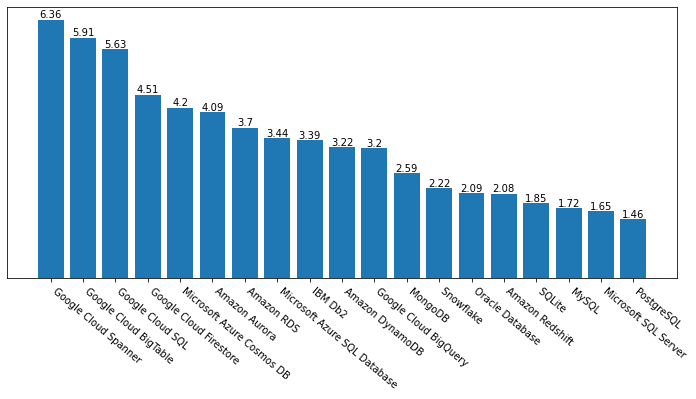

In [19]:
interest = (big_data.iloc[:,2] / big_data.iloc[:,0]).round(2).sort_values()
interest

f, ax = plt.subplots(figsize=(12,5))
r = ax.bar(interest.index, interest.values)
ax.bar_label(r)
ax.set_xticks(interest.index)
ax.set_xticklabels(interest.index, rotation=320, ha='left')
ax.invert_xaxis()
ax.tick_params(left=False, labelleft=False)
plt.show()

We can see that Google Cloud Spanner, a managed relational database product launched in 2020, has the highest level of interest-vs-use ratio in which people are interested 6.3 times more than how often it is actually used. In fact, three other google product has joined the top spot; namely, BigTable, Cloud SQL and Firestore. the observed high level of interest-vs-use ratio may be indicative that these products are growing and people see it as the next big thing.

(how if we plot this according to its launch date?)

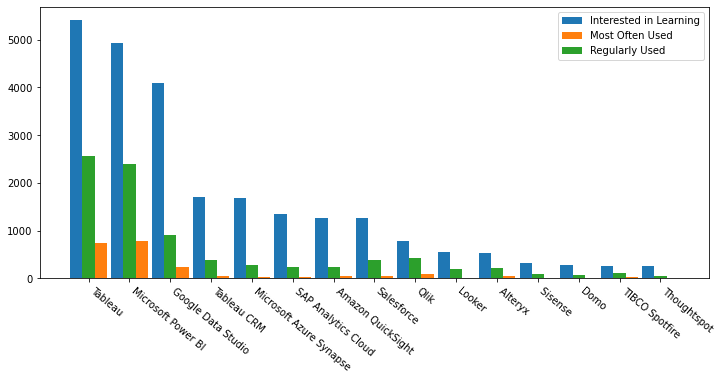

In [20]:
bi_tools_int = count_val(df.loc[:,'Q34_B_Part_1':'Q34_B_OTHER']).rename(df_questions['Q34_B_OTHER'])
bi_tools_reg = count_val(df.loc[:,'Q34_A_Part_1':'Q34_A_OTHER']).rename(df_questions['Q34_A_OTHER'])
bi_tools_oft = count_val(df.loc[:,'Q35']).rename(df_questions['Q35'])
bi_tools = pd.concat([bi_tools_int, bi_tools_reg, bi_tools_oft], axis=1).drop(index=['None', 'Other'])

pos = np.arange(len(bi_tools))
width = 0.3

f, ax = plt.subplots(figsize=(12,5))
ax.bar(pos+height, bi_tools.iloc[:,0], width=width, label = 'Interested in Learning')
ax.bar(pos-height, bi_tools.iloc[:,2], width=width, label = 'Most Often Used')
ax.bar(pos, bi_tools.iloc[:,1], width=width, label = 'Regularly Used')
ax.set_xticks(pos)
ax.set_xticklabels(bi_tools.index, rotation=320, ha='left')
ax.invert_xaxis()
ax.legend()
plt.show()

there is nothing really surprising in this data. but do we have to do the same analysis as above?

## AutoML

In [21]:
# integrate keys. 
pd.options.mode.chained_assignment = None
# replace "No / None" to just 'None'
ntarget = ['Q31_A_Part_9','Q36_A_Part_7','Q37_A_Part_7']
for n in ntarget:
    df.loc[:,n] = df.loc[:,n].str.replace('No / ', '')
# replace inconsistent values
df.loc[:,'Q36_B_Part_6'] = df.loc[:,'Q36_B_Part_6'].str.replace('Cloud ', '')
pd.options.mode.chained_assignment = 'warn'

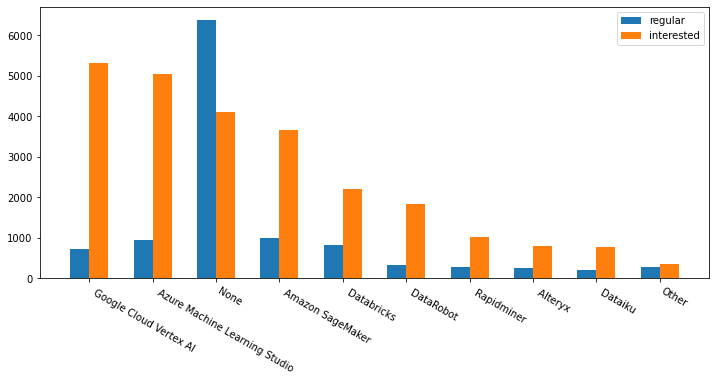

In [22]:
managed_ml = pd.concat([count_val(df.loc[:,'Q31_A_Part_1':'Q31_A_OTHER']).rename(df_questions['Q31_A_OTHER']),
                        count_val(df.loc[:,'Q31_B_Part_1':'Q31_B_OTHER']).rename(df_questions['Q31_B_OTHER'])], axis=1)

managed_ml.sort_values('In the next 2 years, do you hope to become more familiar with any of these managed machine learning products? (Select all that apply) - Selected Choice - Other', inplace=True)

pos = np.arange(len(managed_ml))
width = 0.3

f, ax = plt.subplots(figsize=(12,5))
ax.bar(pos+height/2, managed_ml.iloc[:,0], width=width, label = 'regular')
ax.bar(pos-height/2, managed_ml.iloc[:,1], width=width, label = 'interested')
ax.set_xticks(pos)
ax.set_xticklabels(managed_ml.index, rotation=330, ha='left')
ax.invert_xaxis()
ax.legend()
plt.show()

google has always top the "interest" charts. is it possible that respondents that never actually learned or experienced with this kind of tools tend to choose any google tools that are shown in the survey?

we can see that the majority of respondents don't use automl products. However, it's hard to see how much the competition fare against each other. let's plot the regularly used autoML products without the 'none' constricting our view.

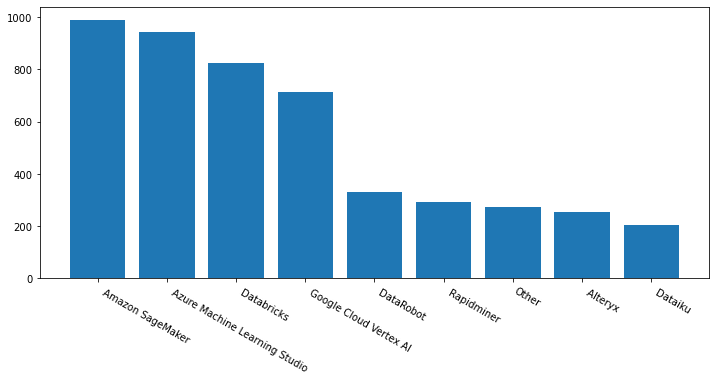

In [23]:
ml_reg = managed_ml.iloc[:,0].drop(index=['None']).sort_values(ascending=False)
pos = np.arange(len(ml_reg))

f, ax = plt.subplots(figsize=(12,5))
plt.bar(pos, ml_reg.values)
ax.set_xticks(pos)
ax.set_xticklabels(ml_reg.index, rotation=330, ha='left')
plt.show()

We can see that Amazon SageMaker is the winner here, but Azure ML Studio, Databricks and Google Cloud Vertex AI is not far behind. Amazon SageMaker and Google Vertex AI was launched relatively recently, that is 2017 and 2021, respectively. Others, like Azure ML studio, Dataiku was launched around 2012-2013, and others, like RapidMiner, was launched way back from 2006. This shows the relatively fast pace of development around the data science and machine learning ecosystem. Therefore, we may see new exciting things in the future.

In [24]:
automl_cat = pd.concat([count_val(df.loc[:,'Q36_A_Part_1':'Q36_A_OTHER']).rename(df_questions['Q36_A_OTHER']),
                        count_val(df.loc[:,'Q36_B_Part_1':'Q36_B_OTHER']).rename(df_questions['Q36_B_OTHER'])], axis=1)
automl_cat

,Do you use any automated machine learning tools (or partial AutoML tools) on a regular basis? (Select all that apply) - Selected Choice - Other,Which categories of automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Other
Other,214,323
"Automated model architecture searches (e.g. darts, enas)",344,2183
"Automated feature engineering/selection (e.g. tpot, boruta_py)",781,3648
"Automation of full ML pipelines (e.g. Google AutoML, H2O Driverless AI)",893,4752
"Automated hyperparameter tuning (e.g. hyperopt, ray.tune, Vizier)",952,3331
"Automated data augmentation (e.g. imgaug, albumentations)",1009,3496
"Automated model selection (e.g. auto-sklearn, xcessiv)",1186,4761
None,6338,3221


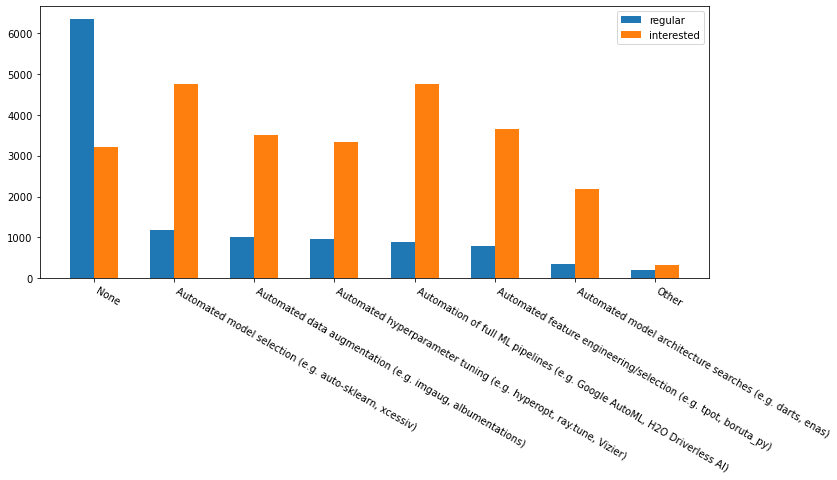

In [25]:
pos = np.arange(len(automl_cat))
width = 0.3

f, ax = plt.subplots(figsize=(12,5))
ax.bar(pos+height/2, automl_cat.iloc[:,0], width=width, label = 'regular')
ax.bar(pos-height/2, automl_cat.iloc[:,1], width=width, label = 'interested')
ax.set_xticks(pos)
ax.set_xticklabels(automl_cat.index, rotation=330, ha='left')
ax.invert_xaxis()
ax.legend()
plt.show()

we can see that just like before, most respondents don't utilize a lot of automated machine learning tools. Among those who did use it first for model selection, data augmentation and hyperparameter tuning. However, there is a lot of interest among respondents to learn about automation of full ML pipelines, or just model selection.

In [26]:
automl_prod = pd.concat([count_val(df.loc[:,'Q37_A_Part_1':'Q37_A_OTHER']).rename(df_questions['Q37_A_OTHER']),
                         count_val(df.loc[:,'Q37_B_Part_1':'Q37_B_OTHER']).rename(df_questions['Q37_B_OTHER'])], axis=1)
automl_prod

,Which of the following automated machine learning tools (or partial AutoML tools) do you use on a regular basis? (Select all that apply) - Selected Choice - Other,Which specific automated machine learning tools (or partial AutoML tools) do you hope to become more familiar with in the next 2 years? (Select all that apply) - Selected Choice - Other
Other,223,280
DataRobot AutoML,271,1545
H2O Driverless AI,316,1387
Databricks AutoML,321,1649
Amazon Sagemaker Autopilot,377,2683
Azure Automated Machine Learning,449,3152
Google Cloud AutoML,751,4817
None,1196,1398


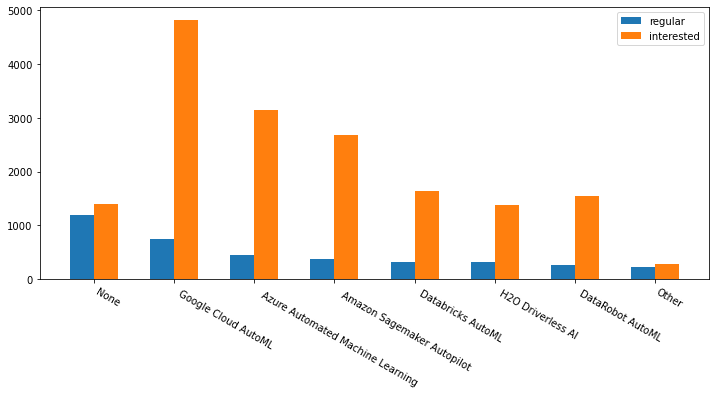

In [27]:
pos = np.arange(len(automl_prod))
width = 0.3

f, ax = plt.subplots(figsize=(12,5))
ax.bar(pos+height/2, automl_prod.iloc[:,0], width=width, label = 'regular')
ax.bar(pos-height/2, automl_prod.iloc[:,1], width=width, label = 'interested')
ax.set_xticks(pos)
ax.set_xticklabels(automl_prod.index, rotation=330, ha='left')
ax.invert_xaxis()
ax.legend()
plt.show()

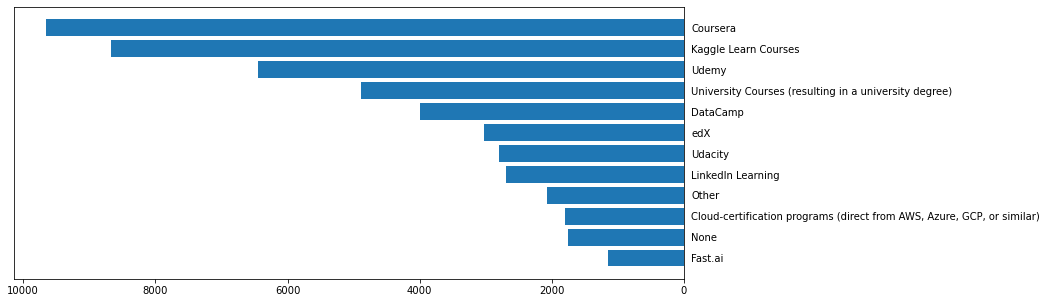

In [28]:
courses = count_val(df.loc[:,'Q40_Part_1':'Q40_OTHER'])

f, ax = plt.subplots(figsize=(12,5))
ax.barh(courses.index, courses.values)
ax.invert_xaxis()
ax.tick_params(left=False, labelleft=False, labelright=True)
# ax.set_xticks(courses.index)
# ax.set_xticklabels(courses.index, rotation=330, ha='left')
plt.show()

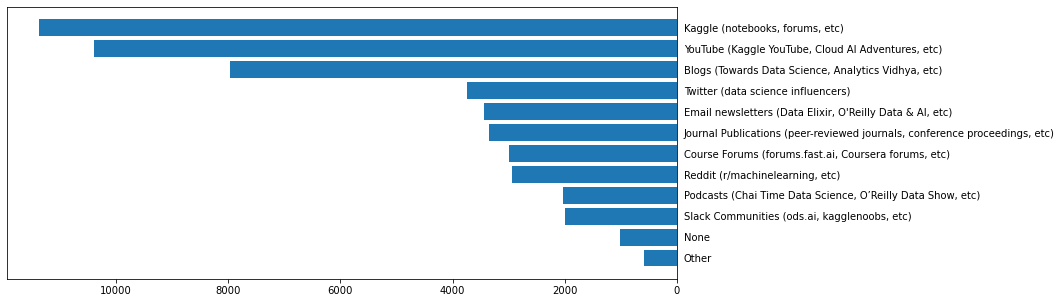

In [29]:
media = count_val(df.loc[:,'Q42_Part_1':'Q42_OTHER'])

f, ax = plt.subplots(figsize=(12,5))
ax.barh(media.index, media.values)
ax.invert_xaxis()
ax.tick_params(left=False, labelleft=False, labelright=True)
# ax.set_xticks(courses.index)
# ax.set_xticklabels(courses.index, rotation=330, ha='left')
plt.show()